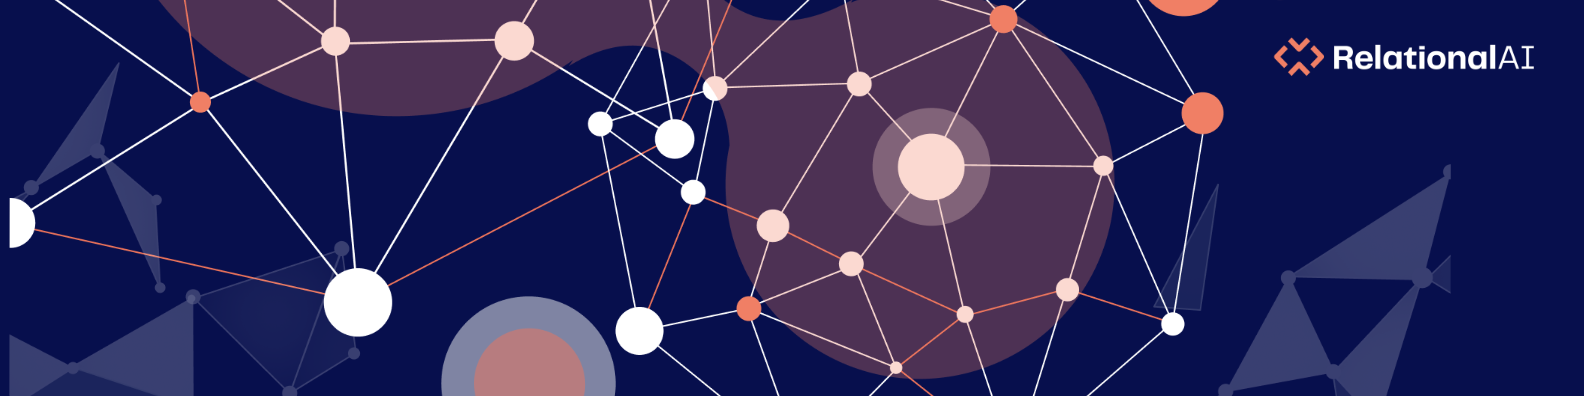

# Fraud Detection

## Overview

In this demo, we will show how the data about users, such as their addresses, phone numbers and emails, can be analyzed to find uncommon patterns.

Most typically, a single user would have a unique address, phone number, and/or email address. Sometimes, two or three users can share an address or a phone number.
It is however not expected that people share, for example, an address with one person, and a phone number with another. This can happen though when scammers re-use phone numbers, email addresses, or physical addresses, while creating fake user accounts.

This demo will focus on detecting such anomalies using RelationalAI knowledge graph.
***

## Let's get started!

### Importing Packages 
We start by installing and importing all the Python packages and modules that we will need, including the `relationalai` package. We then create our tables and define the `Fraud_Detection` model object.

In [ ]:
%pip install relationalai

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std.aggregates import count
from relationalai.std import alias

from typing import Tuple
import pandas as pd

provider = rai.Provider()

In [ ]:
provider.sql("""
begin
	create database if not exists RAI_DEMO;
	create schema if not exists RAI_DEMO.FRAUD_DETECTION;

	create or replace table RAI_DEMO.FRAUD_DETECTION.USER (
		ID NUMBER(38,0) NOT NULL,
		FULLNAME VARCHAR(16777216),
		PHONE_NUMBER VARCHAR(16777216),
		EMAIL VARCHAR(16777216),
		ADDRESS_ID NUMBER(38,0),
		CREDIT_CARD_NUMBER VARCHAR(16)
	);

	create or replace table RAI_DEMO.FRAUD_DETECTION.ADDRESS (
		ID NUMBER(38,0) NOT NULL,
		STREET_ADDRESS VARCHAR(16777216),
		CITY VARCHAR(16777216),
		STATE VARCHAR(16777216)
	);

	insert into RAI_DEMO.FRAUD_DETECTION.USER (ID, FULLNAME, PHONE_NUMBER, EMAIL, ADDRESS_ID, CREDIT_CARD_NUMBER)
	values
	(1,'John Doe','123-456-7890','john.doe@example.com',1,'4111111111111111'),
	(2,'Jane Smith','123-456-7891','weird.email@example.com',2,'5500000000000004'),
	(3,'Bob Brown','123-456-7893','bob.brown@example.com',3,'4111111111111112'),
	(4,'David Evans','123-456-7896','weird.email@example.com',1,'5500000000000005'),
	(5,'Eva Green','123-456-7896','eva.green@example.com',2,'340000000000010'),
	(6,'Grace White','123-456-7898','grace.white@example.com',3,'5500000000000006'),
	(7,'Hannah Lee','123-456-7899','hannah.lee@example.com',1,'340000000000011'),
	(8,'Jack Wilson','222-333-4444','jack.wilson@example.com',4,'4111111111111114'),
	(9,'Kathy Brown','333-444-5555','kathy.brown@example.com',5,'5500000000000007');

	insert into RAI_DEMO.FRAUD_DETECTION.ADDRESS (ID, STREET_ADDRESS, CITY, STATE)
	values
	(1,'123 Fake St','Springfield','IL'),
	(2,'456 Elm St','Springfield','IL'),
	(3,'123 Oak St','Springfield','IL'),
	(4,'678 Pine St','Springfield','IL'),
	(5,'890 Cedar St','Springfield','IL');
end;
""")

In [ ]:

model = rai.Model("Fraud_Detection", ensure_change_tracking=True)

> **Note**. Models represent collections of objects. Objects, like Python objects, have types and properties, which we will define in a bit.

### Importing the Data from Snowflake

Let's now import the data about users into our model.

> **Note**. Due to RelationalAI's tight integration with Snowflake, we can access the imported relation in RAI by simply specifying source when creating a type `source="<my_database.my_schema.my_table>"`.

In [3]:
User = model.Type("User", source="rai_demo.fraud_detection.user")
Address = model.Type("Address", source="rai_demo.fraud_detection.address")

# Add a has_address property matching on the address_id in User table and the id in Address table
User.define(
    has_address = (Address, 'address_id', 'id')
)

> **Note**. We connect to Snowflake and create a Snowpark session using the `rai init` command. A `data stream` between the tables and the `Fraud_Detection` model was created to stream the data from Snowflake to the RAI schema.

### Extending the Model

Now that we have the types referencing our input data tables and representing `User` and `Address` concepts, let's extend our model with three more additional types: `CreditCard`, `Phone` and `Email`.

In [4]:
CreditCard = model.Type("CreditCard")
Phone = model.Type("Phone")
Email = model.Type("Email")

We are adding instances of the `CreditCard`, `Phone` and `Email` types for every value in `User` `credit_card`, `phone_number` and `email` properties. We then set new `has_credit_card`, `has_phone` and `has_email` properties referring to the entities we created.

In [5]:
with model.rule():
    u = User()
    u.set(has_credit_card = CreditCard.add(number = u.credit_card_number))
    u.set(has_phone = Phone.add(number = u.phone_number))
    u.set(has_email = Email.add(address = u.email))

## Getting to know the input data
Let's query our users and their new properties.
We can see how every `User` now has the links to the `Address`, `CreditCard`, `Email` and `Phone`.

In [6]:
with model.query() as select:
    u = User()
    response = select(u.fullname, u.has_address.street_address, alias(u.has_credit_card.number, 'credit_card_number'), alias(u.has_email.address, 'email_address'), alias(u.has_phone.number, 'phone_number'))

response

### Visualizing the Model Graph
To understand our data even better, we can also visualize it.
To do that, we create a `Graph`, having `Nodes` represent users, as well as addresses, phones, emails and credit cards. The properties we set can be used as `Edge`s to link the nodes of the graph together.

In [7]:
graph = Graph(model)
Node, Edge = graph.Node, graph.Edge

Node.extend(User, label = User.fullname, type = 'User')
Node.extend(Address, label = Address.street_address, type = 'Address')
Node.extend(CreditCard, label = CreditCard.number, type = 'CreditCard')
Node.extend(Phone, label = Phone.number, type = 'Phone')
Node.extend(Email, label = Email.address, type = 'Email')

Edge.extend(User.has_address, label = 'has address')
Edge.extend(User.has_credit_card, label = 'has credit card')
Edge.extend(User.has_phone, label = 'has phone')
Edge.extend(User.has_email, label = 'has email')

style = {
    "node": {
        "color": lambda n : 'firebrick' if n.get('focus') and n['type'] == 'User' else
            {'User': 'steelblue', 'Address': 'seagreen', 'CreditCard': 'royalblue', 'Phone': 'darkorange', 'Email': 'mediumpurple'}[n['type']],
        "hover": lambda n: n['type'],
        "size": lambda n: (50 if n.get('focus') else 30) if n['type'] == 'User' else (20 if n.get('focus') else 15),
        "shape": lambda n: 'circle' if n['type'] == 'User' else 'rectangle',
        "border_color": lambda n: 'indianred' if n.get('focus') else 'black'
    },
    "edge": {
        "color": lambda e: 'indianred' if e.get('focus') else 'grey',
        "size": lambda e: 5 if e.get('focus') else 1,
    }
}

graph.visualize(three = False, show_edge_label = True, node_label_size_factor = 1.5, style = style).display(inline = True)

> **Tip**. It is now visually clear that there are groups of users sharing some of their properties. Let's see if we can identify them and analyze further.

## Applying Graph algorithm

Next, as we want to be able to detect uncommon patterns of sharing user personal details, let's identify all groups of users that are somehow connected on our graph. For that purpose, we can start by using the Weakly Connected Components graph algorithm, which detects communities in a graph.

In [8]:
with model.rule():
    u = User()
    community = graph.compute.weakly_connected_component(u)
    u.set(belongs_to = community)

### How many user groups were found?
Let's find out which users belong to which communities — connected groups.

In [9]:
with model.query() as select:
    u = User()
    response = select(u.fullname, u.belongs_to)

groups = response.results.groupby("belongs_to").fullname.apply(list)
for i, g in enumerate(groups):
    print(f"Group {i+1} with {len(g)} connected users: {g}")

Group 1 with 2 connected users: ['Bob Brown', 'Grace White']
Group 2 with 5 connected users: ['David Evans', 'Eva Green', 'Hannah Lee', 'Jane Smith', 'John Doe']
Group 3 with 1 connected users: ['Kathy Brown']
Group 4 with 1 connected users: ['Jack Wilson']


> **Tip**. We can already see that one of the groups is uncommonly large.

## Rule-based detection of uncommon patterns

Now that we've identified all the groups of users in our graph, let's add some rules to automatically detect groups and users in them that show unusual behavior.

First, we can identify groups that are uncommonly large, let's say, having 4 or more users. We create a new type called `LargeGroupUser` to mark users who belong to such groups.

In [10]:
large_group_size = 4
LargeGroupUser = model.Type("LargeGroupUser")

with model.rule():
    u = User()
    count(u, per = [u.belongs_to]) >= large_group_size
    u.set(LargeGroupUser)

Next, let's take a closer look at the marked users.
If we see among them someone sharing email or phone number, but at the same time living in separate places, we can say it is an example of suspicious behavior.

We again create a new `SuspiciousUser` type and write a rule to detect users to set it for.

In [11]:
SuspiciousUser = model.Type("SuspiciousUser")

with model.rule():
    u = LargeGroupUser()
    u2 = LargeGroupUser(belongs_to = u.belongs_to)
    u != u2
    u.has_address != u2.has_address
    with model.case():
        u.has_email == u2.has_email
        u.set(SuspiciousUser)
    with model.case():
        u.has_phone == u2.has_phone
        u.set(SuspiciousUser)

Lastly, we want to mark as suspicious users, who share physical address with another suspicious user.

In [12]:
with model.rule():
    User(has_address = SuspiciousUser().has_address).set(SuspiciousUser)

### Visualizing the results

Let's visualize our graph again: we are now highlighting identified `SuspiciousUser` nodes and edges connecting them in red.

In [ ]:
Node.extend(SuspiciousUser, focus = "suspicious")
with model.rule():
    e = Edge(from_ = SuspiciousUser())
    count(e.from_, per = [e.to]) >= 2 # Edges connecting suspicious users through same property
    e.set(focus = "suspicious")
    Node(e.to).set(focus = "suspicious")

graph.visualize(three = False, show_edge_label = True, node_label_size_factor = 1.5, style = style).display(inline = True)

## Writing results back to Snowflake

As a final step, we want to provide a way to get the result of our analysis from Snowflake. In order to do that, we create a stored procedure, which returns all of the `SuspiciousUser`s identified. We also provide their credit card details and address.

In [14]:
@model.export("rai_demo.fraud_detection")
def suspicious_users() -> Tuple[int, str, str, str]:
    u = SuspiciousUser()
    return u.id, u.fullname, u.has_credit_card.number, u.has_address.street_address

Let's execute the procedure to take a look at the results.

In [15]:
pd.DataFrame(
    provider.sql("call rai_demo.fraud_detection.suspicious_users();"),
    columns = ["id", "fullname", "credit_card_number", "street_address"]
)

id     fullname credit_card_number street_address
0   1     John Doe   4111111111111111    123 Fake St
1   7   Hannah Lee    340000000000011    123 Fake St
2   2   Jane Smith   5500000000000004     456 Elm St
3   4  David Evans   5500000000000005    123 Fake St
4   5    Eva Green    340000000000010     456 Elm St